In [7]:

import yaml
import os

from numpy import *
import luxeics
import h5py

from scipy.interpolate import interp2d,RectBivariateSpline

import matplotlib.pyplot as plt

import luxeics


def Weight(K,W,r,spotsize):
    
    
    
    Constant=60 
    
    Area = pi  * spotsize ** 2
    
    a_0 = Constant/spotsize
    
    X=K*1.61*a_0/1e11
    X=X*exp(-2*(r/spotsize)**2)
    
    w = W*X*exp(-8/3/X)/Area
    
    return w
def sortSecond(val):
    return val[1] 
def Photon_density(xoffset,yoffset,X1,X2,spotsize,sigmaT,W,path,w0,a0,K0):
    
    
    Area = pi  * spotsize ** 2
    Radius=( xoffset + X1 ) ** 2 + ( yoffset + X2 ) ** 2
    
    
    selector = sqrt( Radius) < spotsize
    
    
    
    Photon_Density = sum ( W [ selector ]  ) /  Area
    
    
    
    
    r_inside_Spot = sqrt( Radius[selector])
    
    
    K_inside_Spot=K0[selector]
    W_inside_Spot=W[selector]
    
    
    
    
#     plt.figure(figsize=(14,6))

    

#     ax1=plt.subplot(122,aspect=1)
#     plt.scatter(X1+xoffset, X2+yoffset, color='m', marker='.',lw=0);

#     plt.xlim(-2*spotsize,2*spotsize)
#     plt.ylim(-2*spotsize,2*spotsize)

#     plt.xlabel(r'$x$ (micron)')
#     plt.ylabel(r'$y$ (micron)');
#     plt.title(f'Finite source size, Photon density:{round(Photon_Density,2)} micron^(-2)')


#     ax1.add_patch(plt.Circle((0,0),spotsize,color='C0',fill=False))


#     plt.suptitle(f' sigmaT :{sigmaT} microns W0 : {w0} microns a0:{round(a0)} microns, spotsize:{spotsize} micron')
#     plt.savefig(f'{path}\photon_spectrum_at_focus_{sigmaT}_{spotsize}.png',dpi=200)

    plt.figure(figsize=(10,6))

    plt.subplot(111)
    #W_Positron = Weight(K_inside_Spot,W_inside_Spot,r_inside_Spot,spotsize)
    #Positron_Production_Density = sum ( W_Positron   ) /  Area
    Bins=plt.hist(K_inside_Spot/1e9,bins=linspace(6.0,9.0,50),weights =W_inside_Spot,alpha=1  ,fc='C0',label=f'SigmaT_{sigmaT}_Spotsize_{spotsize}')[0:2]
     
    plt.xlim(6,9)
    plt.legend()
    plt.xlabel('ICS photon energy (GeV)')
    plt.ylabel('positron spectrum at IP')
    
    #plt.savefig(f'{path}\positron_spectrum_at_focus_SigmaT_{sigmaT}_Spotsize_{spotsize}.png',dpi=200)
    
    

    return ( Photon_Density ,Bins)
                                      
    
                                   
def run(spotsize,input_filename,path):
    

    
    
    with h5py.File(f'{path}{os.sep}H_Five{os.sep}'+input_filename+'.h5'  ,'r') as ff:
    #     omega      = ff['final-state/spectrum/omega'][:]/1e9
    #     theta      = ff['final-state/spectrum/theta'][:]*1e6
    #     spectrum   = ff['final-state/spectrum/spectrum'][:]

        K0,K1,K2,K3  = ff['final-state/photon/momentum'][:].T
        X0,X1,X2,X3  = ff['final-state/photon/position'][:].T
        W            = ff['final-state/photon/weight'  ][:]

        #P0,P1,P2,P3  = ff['final-state/electron/momentum'][:].T
    #     X0,X1,X2,X3  = ff['final-state/photon/position'][:].T
    #     We            = ff['final-state/photon/weight'  ][:]
    with open( f'{path}{os.sep}Yml_Files{os.sep}'+input_filename+'.yml' , 'r' ) as stream:
        input_dict = yaml.load(stream, Loader=yaml.SafeLoader)

#         mode             = input_dict['control']['mode']


#         beam_charge      = float( input_dict['beam']['beam_charge'])
#         number_electrons = int( beam_charge / 1.60217653e-19)

    #     sampling         = input_dict['control']['sampling']
#         sampling = mode
        a0               = float(input_dict['laser']['a0'])        
        
        
        w0               = float(input_dict['laser']['w0'])
#         omega0           = float(input_dict['laser']['omega0'])
#         gamma            = float(input_dict['beam']['gamma'])
#         Xr               = 4*gamma*omega0/511*10**(-3)
#         energyspread     = float(input_dict['beam']['energyspread'])
        sigmaT   = float(input_dict['beam']['sigmaX'])
    L = float(input_dict['beam']['L'])

    baseline = 7.5e6

    thetax=K1/K3
    thetay=K2/K3

     

    xoffset = thetax * baseline
    yoffset = thetay * baseline
    
    Pd,Bins=Photon_density(xoffset,yoffset,X1,X2,spotsize,sigmaT,W,path,w0,a0,K0)
    
    
    
    return(Pd,L,Bins)

Files and Directories in 'C:\Users\Dupish\Documents\GitHub\luxeics\Photon_Density\L_Para_Run':


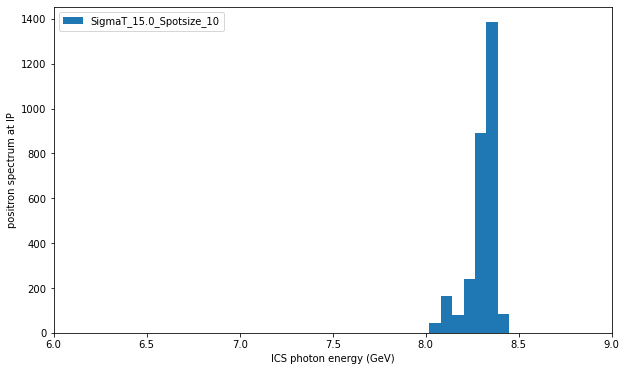

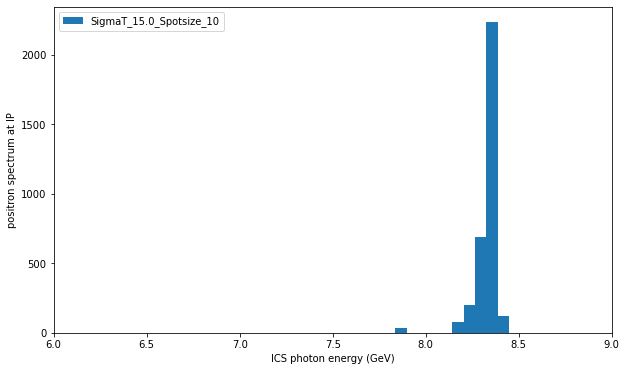

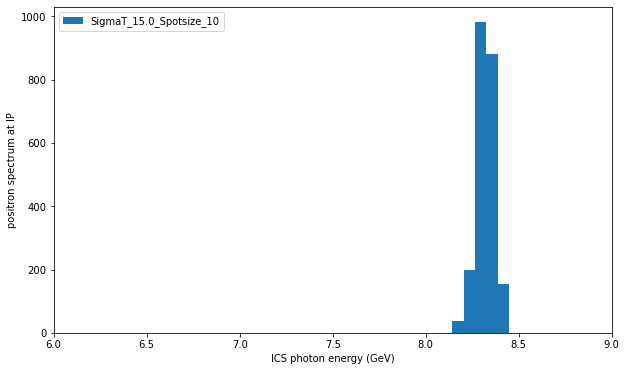

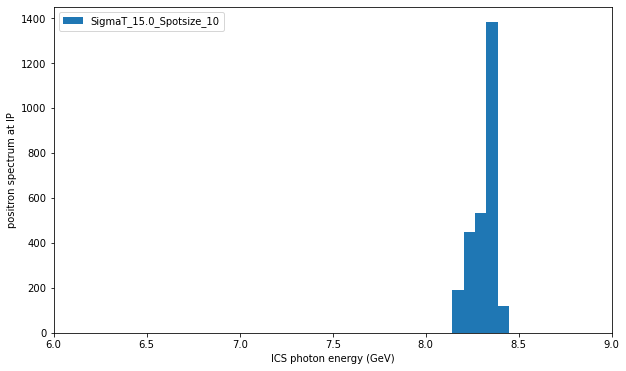

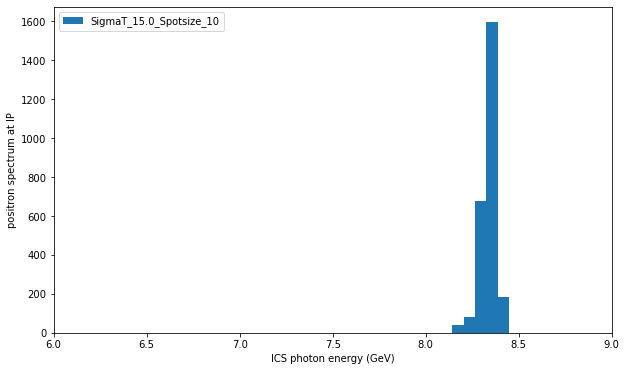

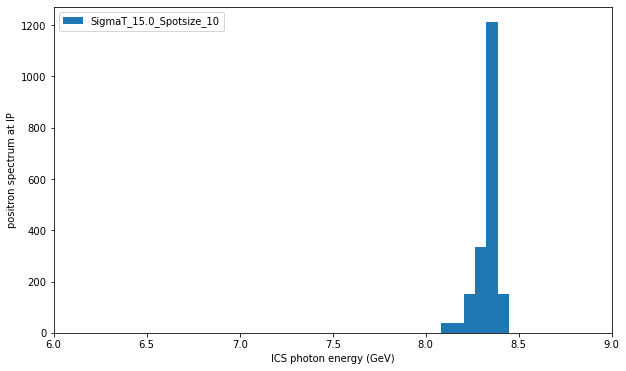

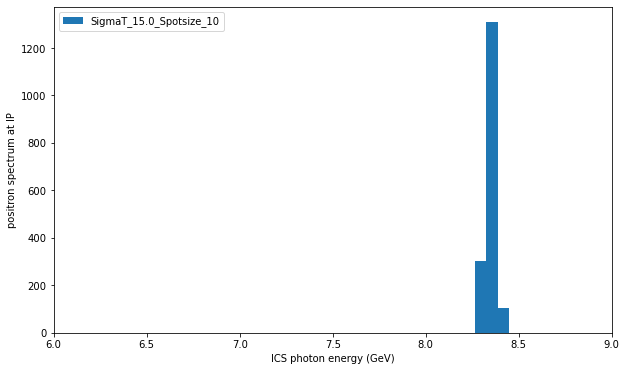

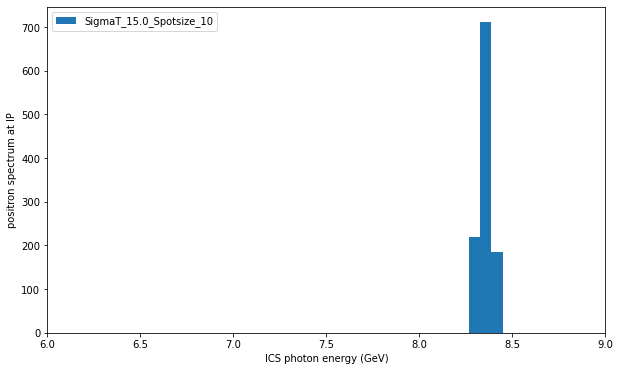

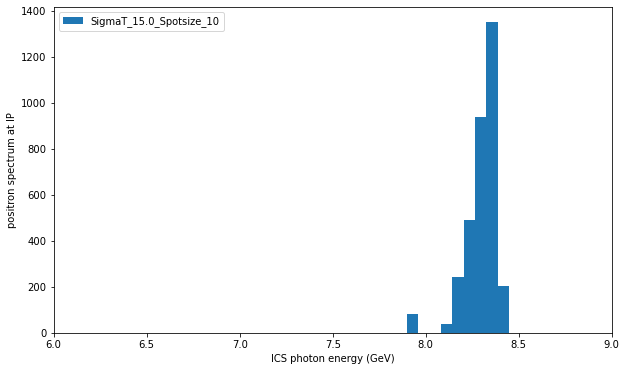

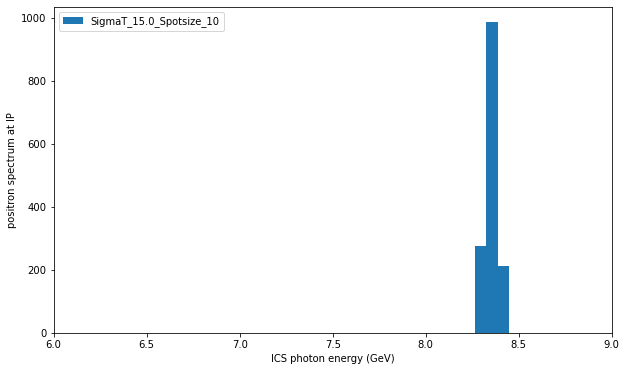

In [8]:

input_filename = f"{os.getcwd()}{os.sep}YML_Files{os.sep}L_Para_Run"


spotsize = 10
with open( input_filename + '.yml', 'r' ) as stream:
               
            
            
            input_dict = yaml.load(stream, Loader=yaml.SafeLoader)
            

            directory	=input_dict['control']['folder']


path = f"{os.getcwd()}{os.sep}Photon_Density{os.sep}{directory}"


object = os.scandir(path+f'{os.sep}H_Five')
print("Files and Directories in '% s':" % path)
Info=[]
for n in object :
    


        Info.append( run(spotsize,f'{os.path.splitext(n.name)[0]}', f'{path}'))

        #Bins.append( run(spotsize,f'{os.path.splitext(n.name)[0]}', f'{path}')[1])        
        

object.close()

Info.sort(key = sortSecond)


In [10]:
a=len(Info)
print(a)
PD_Constant_W0=zeros((a,2))
Bins=[]

for i in range(a):
    PD_Constant_W0[i,0]=Info[i][0]
    PD_Constant_W0[i,1]=Info[i][1]
    Bins.append(Info[i][2])
print(PD_Constant_W0)

10
[[1.06596835e+01 7.50000000e+05]
 [9.18714283e+00 1.50000000e+06]
 [1.07006220e+01 2.25000000e+06]
 [7.15708667e+00 3.00000000e+06]
 [8.49803256e+00 3.75000000e+06]
 [8.20898566e+00 4.50000000e+06]
 [6.14267399e+00 5.25000000e+06]
 [5.47087585e+00 6.00000000e+06]
 [3.54659163e+00 6.75000000e+06]
 [4.69586925e+00 7.50000000e+06]]


<ipython-input-14-bb4ead99db7b>:28: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x,y,z)


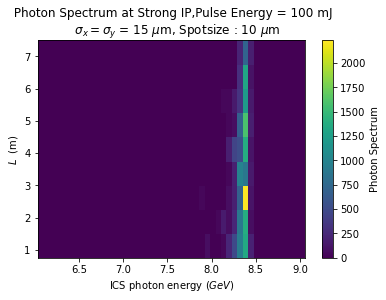

In [14]:
'''
Creating Data For colour mesh

'''

Nz = len(Bins[0][0])
z  = zeros((a,Nz))
Nx = len(Bins[0][1])
x=zeros((a,Nx))
for i in range(0,a):
    z[i]=array(Bins[i][0])
    
    
y= PD_Constant_W0[:,1]*10**(-6)
x=array(Bins[0][1])    



x_temp=[]
for i in range(len(x)-1):
    
    x_temp.append(0.5*(x[i]+x[i+1]))
    
x_temp.append(x[len(x)-1]+x[len(x)-1]-x[len(x)-2])
x=array(x_temp)
plt.title(f" Photon Spectrum at Strong IP,Pulse Energy = 100 mJ\n   $\sigma_x=\sigma_y$ = {15} $\mu$m, Spotsize : {spotsize} $\mu$m")
#  w_0= 5 $
plt.pcolormesh(x,y,z)
plt.xlabel('ICS photon energy ($GeV$)')
plt.ylabel(f'$L$  (m)')

plt.colorbar(label='Photon Spectrum')
plt.savefig(f'{path}\PhotoSpectrum{spotsize}_Finite.png',dpi=200)


In [33]:


plt.plot((PD_Constant_w0)[:,1],(PD_Constant_w0)[:,0])
plt.xlabel('( sigmaT $[microns]$ )')
plt.ylabel('(Photon Density )$[microns]^-2$')

plt.title(f'Energy Conserved, Spotsize:{spotsize} microns')
plt.legend()
plt.savefig(f'{path}\PhotonDensity_vs_sigmaT_Spotsize{spotsize}_Finite.png',dpi=200)



NameError: name 'PD_Constant_w0' is not defined

In [164]:
print(PD_Constant_W0)

[[ 7.99673378  5.        ]
 [ 2.38574942 10.        ]
 [ 1.67173916 15.        ]
 [ 0.47393886 20.        ]
 [ 0.72909486 25.        ]
 [ 0.28974613 30.        ]
 [ 0.14382582 35.        ]
 [ 0.14770198 40.        ]
 [ 0.42385602 45.        ]
 [ 0.54409212 50.        ]]


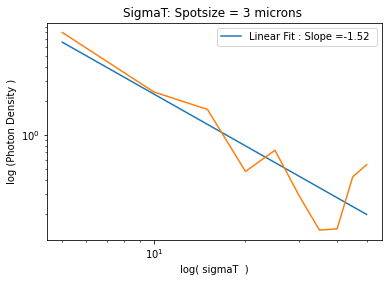

In [165]:
z=(polyfit(log(PD_Constant_w0[:,1].astype('float64')),log(PD_Constant_w0[:,0].astype('float64')),1))
poly = poly1d(z)
x=log(PD_Constant_w0[:,1].astype('float64'))
y=poly(x)
plt.plot(exp(x),exp(y),label=f'Linear Fit : Slope ={round(z[0],2)} ')
plt.plot((PD_Constant_w0[:,1]),(PD_Constant_w0[:,0]))
plt.title(f'SigmaT: Spotsize = {spotsize} microns ')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('log( sigmaT  )')
plt.ylabel(f'log (Photon Density )')
plt.legend()
plt.savefig(f'{path}\PhotonDensity_vs_sigmaT_Spotsize{spotsize}_Finite_Log_Scale.png',dpi=200)


In [168]:
'''
Saving the Data
'''
Pd=array(PD_Constant_w0)

import pandas as pd
import numpy as np
import os
n=np.shape(Pd)
print(n)
Data=np.zeros((n))
Data[:,0]=Pd[:,0]
Data[:,1]=Pd[:,1]
df=pd.DataFrame(Data)

List=["Photon Density ","SigmaT","IDK"]
df.to_csv(f'{path}\Photon_Density_Spotsize{spotsize}.txt',header=List , index=None, sep="\t", mode='w')



print(df)

(10, 3)
          0     1    2
0  7.996734   5.0  0.0
1  2.385749  10.0  0.0
2  1.671739  15.0  0.0
3  0.473939  20.0  0.0
4  0.729095  25.0  0.0
5  0.289746  30.0  0.0
6  0.143826  35.0  0.0
7  0.147702  40.0  0.0
8  0.423856  45.0  0.0
9  0.544092  50.0  0.0


In [169]:
'''
Reading the text files
The final array p does not contain the Header files

'''
print(pd.read_csv(f'{path}\Photon_Density_Spotsize{spotsize}.txt',header=None , sep="\t"))

r=pd.read_csv(f'{path}\Photon_Density_Spotsize{spotsize}.txt',header=0 , sep="\t")
Pd_SigmaT=pd.DataFrame.to_numpy(r)

                      0       1    2
0       Photon Density   SigmaT  IDK
1      7.99673378017644     5.0  0.0
2    2.3857494220913247    10.0  0.0
3    1.6717391596355902    15.0  0.0
4   0.47393886023762766    20.0  0.0
5    0.7290948648489659    25.0  0.0
6    0.2897461268385033    30.0  0.0
7   0.14382581785404272    35.0  0.0
8   0.14770198273399832    40.0  0.0
9     0.423856015433656    45.0  0.0
10   0.5440921226663785    50.0  0.0


In [115]:
os.path.splitext(n.name)[0]

'SigmaT9_0'